# Explain Features with 2D Projections
Part of our introduction figure is to explain how we extract information about a particle given its local environment. Lets do this with graphics about a particle moving thorugh a 2D lattice

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.stats import multivariate_normal
from typing import Tuple
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Configuration

In [2]:
particle = np.array([1.0, 1.35])
particle_x, particle_y = particle
velocity = np.array([0.55, 0.03])
velocity_orth = [-velocity[1], velocity[0]]
lattice = [-0.6, 3.6]

## Functions for Making a Background Lattice and Projectile
Many of my figures are going to use a lattice of atoms with a projectile moving through it. 
Let's make a function that will allow us to change that easily

In [3]:
def plot_lattice(ax: plt.Axes, unit_cell: Tuple[float, float], atom_color: str = 'darkslategray'):
    """Plot a lattice of atoms on the graph
    
    Args:
        ax: Axes on which to plot
        unit_cell: x- and y-spacing of atoms
        atom_size: Width of an atom
        atom_color: Color of the atom
    """    
    # Compute the locations of each atom
    end_x = np.ceil(ax.get_xlim()).max()
    atom_pos_x = np.arange(0, end_x + 1, unit_cell[0])
    
    end_y = np.ceil(ax.get_ylim()).max()
    atom_pos_y = np.arange(0, end_y + 1, unit_cell[1])
    
    # Place it on the axis
    atom_pos_xx, atom_pos_yy = np.meshgrid(atom_pos_x, atom_pos_y)
    col = ax.scatter(atom_pos_xx, atom_pos_yy, color=atom_color, s=400, edgecolor='none')
    
    # Make the atom coordinates
    return np.stack((atom_pos_xx, atom_pos_yy), axis=2).reshape((-1, 2))

# One showing the particle movement
With the disturbed electron cloud

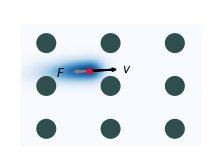

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 1.7))

ratio = fig.get_size_inches()[1] / fig.get_size_inches()[0]
ax.set_xlim(*lattice)
ax.set_ylim(*np.multiply(lattice, ratio))
ax.axison = False

# Make a smear along the direction of travel
xx, yy = np.meshgrid(*[np.linspace(*x, 512) for x in [ax.get_xlim(), ax.get_ylim()]])
coords = np.stack([xx, yy], axis=2)
disp = coords - [particle_x, particle_y]

disp_forward = np.dot(disp, velocity / np.linalg.norm(velocity))
disp_forward[disp_forward > 0] *= 3
disp_ortho = np.dot(disp, velocity_orth / np.linalg.norm(velocity))

mv = np.exp(- (disp_forward ** 2 + (disp_ortho * 4) ** 2))
ax.matshow(mv, vmin=0, vmax=1, cmap='Blues',
          extent=ax.get_xlim() + ax.get_ylim(), origin='bottom', zorder=-10, alpha=0.9)

# Put the lattice down
plot_lattice(ax, unit_cell=[1.5, 1.])

# Put the particle in it
ax.scatter([particle_x], [particle_y], color='crimson', s=30)

# Show the velocity
ax.arrow(particle_x, particle_y, dx=velocity[0], dy=velocity[1],
         lw=2, head_width=0.05, zorder=-1, color='k')
ax.text(particle_x + velocity[0] * 1.4, particle_y + velocity[1] * 1.4,
        '$v$', fontsize=12, va='center', fontweight='bold')

ax.arrow(particle_x, particle_y, dx=-0.5 * velocity[0], dy=-0.5 * velocity[1],
         lw=2, head_width=0.05, zorder=-1, color='gray')
ax.text(particle_x - 1.4 * velocity[0], particle_y - 1.4 * velocity[1],
        '$F$', fontsize=12, va='center', fontweight='bold')

ax.set_position((0, 0, 1, 1))
fig.savefig('figures/just-particle.png', dpi=320, pad_inches=0)

## Make the Charge Density
Show the local density at points along the path

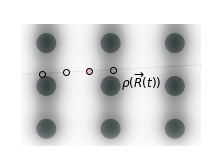

In [5]:
fig, ax = plt.subplots(figsize=(2.5, 1.7))

ratio = fig.get_size_inches()[1] / fig.get_size_inches()[0]
ax.set_xlim(*lattice)
ax.set_ylim(*np.multiply(lattice, ratio))
ax.axison = False

# Put the lattice down
atom_coords = plot_lattice(ax, unit_cell=[1.5, 1.])


# Make a fake electron density
xx, yy = np.meshgrid(*[np.linspace(*x, 512) for x in [ax.get_xlim(), ax.get_ylim()]])
coords = np.stack([xx, yy], axis=2)  # Grid points

dist_from_atoms = np.linalg.norm(coords[:, :, None, :] - atom_coords, axis=-1)
rho = np.exp(- 3 * dist_from_atoms ** 2).sum(axis=-1) ** 2

ax.matshow(rho, vmin=0, vmax=1.5, cmap='Greys',
          extent=ax.get_xlim() + ax.get_ylim(), origin='bottom',
           zorder=1, alpha=0.7)

# Put the particle in it
ax.scatter([particle_x], [particle_y], color='crimson', s=30, alpha=.7)

# Plot a line with a few points along the axis
t = [-2, -1, 0, 1]
points = np.add([particle_x, particle_y], 
               np.multiply(np.array(velocity)[:, None], t).T)
ax.plot(points[:, 0], points[:, 1], 'ko', lw=1, fillstyle='none')

ax.plot(particle_x + np.multiply([-10, 10], velocity[0]),
        particle_y + np.multiply([-10, 10], velocity[1]),
        ':', zorder=-1, lw=1, color='gray')

ax.text(1.75, 1.1,
        '$\\rho(\overrightarrow{R}(t))$', fontsize=12, 
        va='center', ha='left', fontweight='bold')

ax.set_position((0, 0, 1, 1))
fig.savefig('figures/electron-density.png', dpi=320, pad_inches=0)

## Make the Coulomb Repulsion
Show force vectors

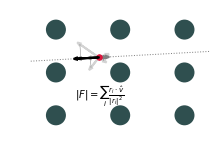

In [6]:
fig, ax = plt.subplots(figsize=(2.5, 1.7))

ratio = fig.get_size_inches()[1] / fig.get_size_inches()[0]
ax.set_xlim(*lattice)
ax.set_ylim(*np.multiply(lattice, ratio))
ax.axison = False

# Put the lattice down
atom_coords = plot_lattice(ax, unit_cell=[1.5, 1.])

# Ge the direction and magnitude Coulomb force between the projectile and the atoms
disp = np.subtract(atom_coords, (particle_x, particle_y))
dist = np.linalg.norm(disp, axis=1)
forces = np.divide(disp, dist[:, None] ** 3)
forces = forces[np.argsort(np.linalg.norm(forces, axis=1))]

# Plot the total force
total_force = forces.sum(axis=0)
total_force = np.multiply(np.dot(total_force, velocity[:, None]), velocity) / np.linalg.norm(velocity) ** 2
total_force *= -0.2
ax.arrow(particle_x, particle_y, dx=total_force[0], dy=total_force[1],
         lw=2, head_width=0.05, color='k', zorder=2)

for force in forces[-4:]:
    force = -force * 0.2
    ax.arrow(particle_x, particle_y, dx=force[0], dy=force[1],
             lw=2, head_width=0.05, color='lightgray', zorder=0)  # Coulomb force
    proj_force = np.multiply(np.dot(force, velocity), velocity) / np.linalg.norm(velocity) ** 2
    ax.arrow(particle_x, particle_y, dx=proj_force[0], dy=proj_force[1],
             lw=2, head_width=0.05, color='gray', zorder=1)  # Projected force
    off_axis = force - proj_force
    ax.plot([particle_x + proj_force[0], particle_x + force[0]],
            [particle_y + proj_force[1], particle_y + force[1]],
            lw=0.5, color='gray', zorder=1)

# Put the particle and its path 
ax.scatter([particle_x], [particle_y], color='crimson', s=30, zorder=2)
ax.plot(particle_x + np.multiply([-10, 10], velocity[0]),
        particle_y + np.multiply([-10, 10], velocity[1]),
        ':', zorder=-1, lw=1, color='gray')

# Put an equation on here
ax.text(0.45, 0.4, '$\\left|F\\right|=\\sum_i\\frac{r_i\\cdot\\hat{v}}{\\left|r_i\\right|^2}$')


ax.set_position((0, 0, 1, 1))
fig.savefig('figures/coulomb-replusion.png', dpi=320, pad_inches=0)

## Make the Force
Show force vectors

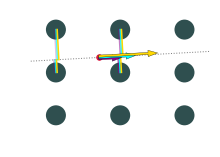

In [7]:
fig, ax = plt.subplots(figsize=(2.5, 1.7))

ratio = fig.get_size_inches()[1] / fig.get_size_inches()[0]
ax.set_xlim(*lattice)
ax.set_ylim(*np.multiply(lattice, ratio))
ax.axison = False

# Put the lattice down
atom_coords = plot_lattice(ax, unit_cell=[1.5, 1.])

# Get the direction and magnitude Coulomb force between the projectile and the atoms
disps = np.subtract(atom_coords, (particle_x, particle_y))
dists = np.linalg.norm(disps, axis=1)
atom_inds = np.argsort(dists)  # Nearest to farthest
proj = np.dot(disps, velocity) / np.linalg.norm(velocity)

# Place a line from the atom to the trajectory
for i, (eta, color) in enumerate(zip((1, 2, 16), ['darkmagenta', 'cyan', 'gold'])):
    i -= 1
    for ind in atom_inds[:4]:
        # Get the direction vector
        disp = disps[ind, :]
        coords = atom_coords[ind]
        atom_to_traj = np.add((particle_x, particle_y), np.multiply(np.dot(disp, velocity), velocity) / np.linalg.norm(velocity) ** 2)
        
        # We will shift it by a certain amount for difference etas
        shift = np.multiply(0.03 * i, velocity) / np.linalg.norm(velocity)
        
        # Make the alpha based on the distance
        alpha = np.exp(-1 * (dists[ind] / eta) ** 2)
        ax.plot(*zip(coords + shift, atom_to_traj + shift), color=color, alpha=alpha)
        
    # Get a total contribution
    value = np.power((np.exp(-1 * (dists / eta) ** 2) * proj).sum(), 1./4)
    
    shift = np.multiply(0.03 * i, velocity_orth) / np.linalg.norm(velocity)
    direction = np.multiply(value, velocity)
    ax.arrow(*(particle + shift), *direction, width=0.05,
            lw=0.3, facecolor=color, zorder=2)
    
# Plot a density around the projectile
xx, yy = np.meshgrid(*[np.linspace(*x, 512) for x in [ax.get_xlim(), ax.get_ylim()]])
coords = np.stack([xx, yy], axis=2)  # Grid points


# Put the particle and its path 
ax.scatter([particle_x], [particle_y], color='crimson', s=30, zorder=2)
ax.plot(particle_x + np.multiply([-10, 10], velocity[0]),
        particle_y + np.multiply([-10, 10], velocity[1]),
        ':', zorder=-1, lw=1, color='gray')

ax.set_position((0, 0, 1, 1))

fig.savefig('figures/atomic-enviroment-multivector.png', dpi=320, pad_inches=0)

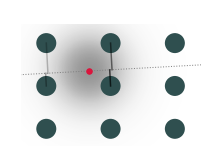

In [8]:
fig, ax = plt.subplots(figsize=(2.5, 1.7))

ratio = fig.get_size_inches()[1] / fig.get_size_inches()[0]
ax.set_xlim(*lattice)
ax.set_ylim(*np.multiply(lattice, ratio))
ax.axison = False

# Put the lattice down
atom_coords = plot_lattice(ax, unit_cell=[1.5, 1.])

# Get the direction and magnitude Coulomb force between the projectile and the atoms
disps = np.subtract(atom_coords, (particle_x, particle_y))
dists = np.linalg.norm(disps, axis=1)
atom_inds = np.argsort(dists)  # Nearest to farthest
proj = np.dot(disps, velocity) / np.linalg.norm(velocity)

# Place a line from the atom to the trajectory
eta = 1
color = 'black'
for ind in atom_inds[:4]:
    # Get the direction vector
    disp = disps[ind, :]
    coords = atom_coords[ind]
    atom_to_traj = np.add((particle_x, particle_y), np.multiply(np.dot(disp, velocity), velocity) / np.linalg.norm(velocity) ** 2)

    # Make the alpha based on the distance
    alpha = np.exp(-1 * (dists[ind] / eta) ** 2)
    ax.plot(*zip(coords, atom_to_traj), color=color, alpha=alpha)
    
# Plot the background
xx, yy = np.meshgrid(*[np.linspace(*x, 512) for x in [ax.get_xlim(), ax.get_ylim()]])
coords = np.stack([xx, yy], axis=2)  # Grid points

zz = np.exp(-(np.linalg.norm(coords - particle, axis=2) / eta) ** 2)
ax.matshow(zz, vmin=0, vmax=1.5, cmap='Greys',
          extent=ax.get_xlim() + ax.get_ylim(), origin='bottom',
           zorder=-1, alpha=0.7)

        
# Put the particle and its path 
ax.scatter([particle_x], [particle_y], color='crimson', s=30, zorder=2)
ax.plot(particle_x + np.multiply([-10, 10], velocity[0]),
        particle_y + np.multiply([-10, 10], velocity[1]),
        ':', zorder=0, lw=1, color='gray')

ax.set_position((0, 0, 1, 1))

fig.savefig('figures/atomic-enviroment-density.png', dpi=320, pad_inches=0)